# Reproducible Results and Visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from IPython.display import HTML

## Knowledge Probing Results

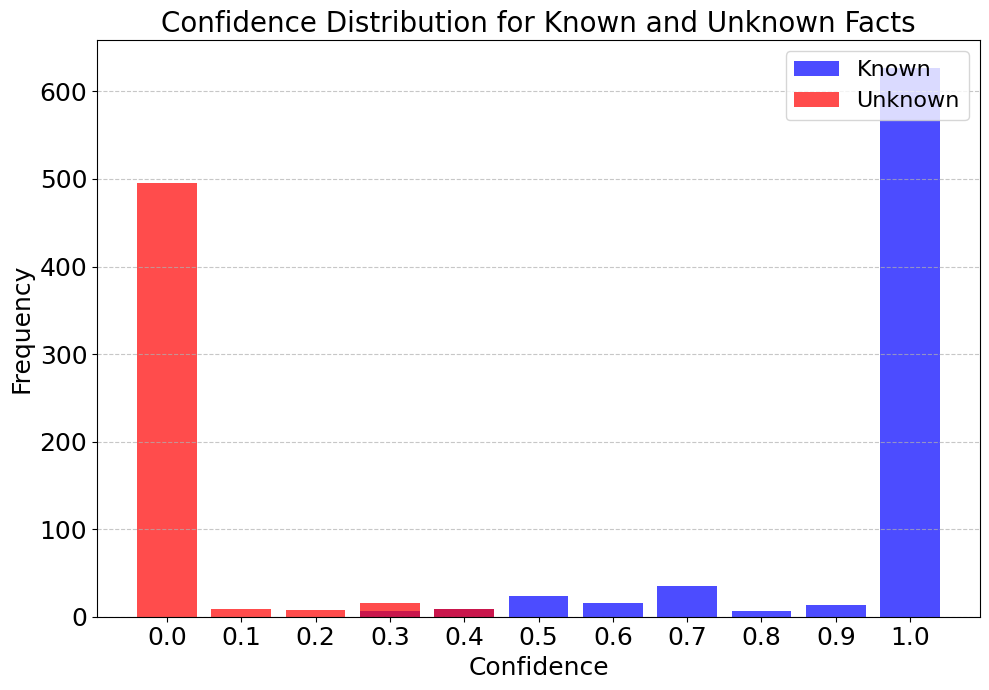

In [3]:
model_names = ["qwen-2.5-3b"]
task_names = ["grow", "code", "math"]

data = []

for task in task_names:
    for model in model_names:
        with open(f"../data/eval_results/{task}/probe_evaluated/test_100_depth_4_{model}.pkl", "rb") as f:
            data.extend(pickle.load(f))

    
knowledgable_confidence = []
unknowledgable_confidence = []

for item in data:
    if item['knowledgable']:
        knowledgable_confidence.append(item['knowledge_confidence'])
    else:
        unknowledgable_confidence.append(item['knowledge_confidence'])

# --- Solution for discrete bins ---
# Your discrete values are 0, 0.1, 0.2, ..., 1.0 (11 distinct values).
# To center histogram bars on these values, we need bin edges halfway between them.
# For a value 'v', the bin should span from 'v - 0.05' to 'v + 0.05'.
# So, the edges will be: -0.05, 0.05, 0.15, ..., 0.95, 1.05.
# This creates 11 bins, each 0.1 wide.
bin_edges = np.arange(-0.05, 1.15, 0.1)
# print(f"Bin edges: {bin_edges}") # For verification: [-0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05]

plt.figure(figsize=(10, 7)) # Adjusted figure size for better readability

# Plot histogram for 'knowledgable_confidence'
plt.hist(knowledgable_confidence,
         bins=bin_edges,          # Use the custom bin edges
         alpha=0.7,               # Transparency
         label='Known',
         color='blue',
         rwidth=0.8)              # Reduce bar width slightly to create small gaps if desired

# Plot histogram for 'unknowledgable_confidence'
plt.hist(unknowledgable_confidence,
         bins=bin_edges,          # Use the same custom bin edges
         alpha=0.7,               # Transparency
         label='Unknown',
         color='red',
         rwidth=0.8)              # Reduce bar width slightly

plt.title('Confidence Distribution for Known and Unknown Facts', fontsize=20)
plt.xlabel('Confidence', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
# Tick font size
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Set x-axis ticks to be the center of the bins (your discrete values)
tick_centers = np.arange(0, 1.1, 0.1) # These are your actual discrete values: [0.  0.1 0.2 ... 1. ]
plt.xticks(tick_centers, [f"{x:.1f}" for x in tick_centers]) # Format ticks to one decimal place

plt.legend(loc='upper right', fontsize=16) # Legend for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid for easier frequency reading
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping
plt.show()

## Knowledge Injection Results

### Main Table

In [4]:
def is_answer_correct(item):
    return item["final_answer_correct"]

def is_reasoning_correct(item):
    return all([k['nli_class'] == 'entailment' for k in item['required_knowledge']])

def is_correct(item):
    return is_answer_correct(item) and is_reasoning_correct(item)

def rate(data, func):
    return sum([func(item) for item in data]) / len(data)

In [5]:
for task in task_names:
    for model in model_names:
        with open(f"../data/eval_results/{task}/injection_evaluated/original_100_depth_4_{model}_1.pkl", "rb") as f:
            original_data = pickle.load(f)

        with open(f"../data/eval_results/{task}/injection_evaluated/all_100_depth_4_{model}_1.pkl", "rb") as f:
            all_data_1 = pickle.load(f)
            
        with open(f"../data/eval_results/{task}/injection_evaluated/base_100_depth_4_{model}_1.pkl", "rb") as f:
            base_data_1 = pickle.load(f)

        with open(f"../data/eval_results/{task}/injection_evaluated/base_100_depth_4_{model}_10.pkl", "rb") as f:
            base_data_10 = pickle.load(f)

        with open(f"../data/eval_results/{task}/injection_evaluated/base_100_depth_4_{model}_100.pkl", "rb") as f:
            base_data_100 = pickle.load(f)
            
        print(f"Task: {task}")
        print(f"Model: {model}")
        print(f"Original: {rate(original_data, is_correct):.2f} (HP) {rate(original_data, is_answer_correct):.2f} (AP) {rate(original_data, is_reasoning_correct):.2f} (FKE)")
        print(f"Injection (All): {rate(all_data_1, is_correct):.2f} (HP) {rate(all_data_1, is_answer_correct):.2f} (AP) {rate(all_data_1, is_reasoning_correct):.2f} (FKE)")
        print(f"Injection (KAS=1): {rate(base_data_1, is_correct):.2f} (HP) {rate(base_data_1, is_answer_correct):.2f} (AP) {rate(base_data_1, is_reasoning_correct):.2f} (FKE)")
        print(f"Injection (KAS=10): {rate(base_data_10, is_correct):.2f} (HP) {rate(base_data_10, is_answer_correct):.2f} (AP) {rate(base_data_10, is_reasoning_correct):.2f} (FKE)")
        print(f"Injection (KAS=100): {rate(base_data_100, is_correct):.2f} (HP) {rate(base_data_100, is_answer_correct):.2f} (AP) {rate(base_data_100, is_reasoning_correct):.2f} (FKE)")

Task: grow
Model: qwen-2.5-3b
Original: 0.00 (HP) 0.23 (AP) 0.00 (FKE)
Injection (All): 0.73 (HP) 0.89 (AP) 0.81 (FKE)
Injection (KAS=1): 0.55 (HP) 0.77 (AP) 0.61 (FKE)
Injection (KAS=10): 0.33 (HP) 0.57 (AP) 0.43 (FKE)
Injection (KAS=100): 0.18 (HP) 0.28 (AP) 0.22 (FKE)
Task: code
Model: qwen-2.5-3b
Original: 0.17 (HP) 0.28 (AP) 0.38 (FKE)
Injection (All): 0.17 (HP) 0.25 (AP) 0.45 (FKE)
Injection (KAS=1): 0.21 (HP) 0.32 (AP) 0.43 (FKE)
Injection (KAS=10): 0.14 (HP) 0.24 (AP) 0.33 (FKE)
Injection (KAS=100): 0.12 (HP) 0.25 (AP) 0.32 (FKE)
Task: math
Model: qwen-2.5-3b
Original: 0.56 (HP) 0.69 (AP) 0.69 (FKE)
Injection (All): 0.69 (HP) 0.75 (AP) 0.86 (FKE)
Injection (KAS=1): 0.60 (HP) 0.72 (AP) 0.78 (FKE)
Injection (KAS=10): 0.56 (HP) 0.69 (AP) 0.71 (FKE)
Injection (KAS=100): 0.47 (HP) 0.60 (AP) 0.62 (FKE)


### Answer Pass and Full Knowledge Entailment

In [6]:
def get_transition_counts(data_list, is_answer_correct_func, is_reasoning_correct_func):
    transition_counts = np.zeros((2, 2), dtype=int)
    if not data_list: 
        return transition_counts
    for item in data_list:
        if not isinstance(item, dict):
            continue
        ans_correct = is_answer_correct_func(item)
        reas_correct = is_reasoning_correct_func(item)
        if reas_correct:
            if ans_correct:
                transition_counts[0, 0] += 1
            else:
                transition_counts[0, 1] += 1
        else:
            if ans_correct:
                transition_counts[1, 0] += 1
            else:
                transition_counts[1, 1] += 1
    return transition_counts


# --- Data Aggregation (unchanged) ---
models = ["llama-3.2-1b", "llama-3.2-3b", "qwen-2.5-1.5b", "qwen-2.5-3b"]
tasks = ['grow', 'code', 'math']
scopes = [1, 10, 100]
all_task_counts = {}

for task in tasks:
    aggregated_counts = np.zeros((2, 2), dtype=int)
    base_file_dir = f"../data/eval_results/{task}/injection_evaluated/"
    print(f"\n--- Processing Task: {task.upper()} ---")
    for model in models:
        for scope in scopes:
            file_name = f"base_100_depth_4_{model}_{scope}.pkl"
            file_path = os.path.join(base_file_dir, file_name)
            try:
                with open(file_path, "rb") as f:
                    data = pickle.load(f)
                transition_counts = get_transition_counts(data, is_correct, is_reasoning_correct)
                aggregated_counts += transition_counts
            except FileNotFoundError:
                pass 
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    all_task_counts[task] = aggregated_counts


# ===================================================================
# 2. Sankey Visualization Function (unchanged)
# ===================================================================
def create_sankey_amcharts(count_matrix, task_name, source_labels, target_labels):
    source_totals = count_matrix.sum(axis=1)
    target_totals = count_matrix.sum(axis=0)
    total_flow = count_matrix.sum()
    links_data = []
    if total_flow > 0:
        source_final_labels = {
            label: f"{label}\n{(source_totals[i] / total_flow) * 100:.1f}%"
            for i, label in enumerate(source_labels)
        }
        target_final_labels = {
            label: f"{label}\n{(target_totals[i] / total_flow) * 100:.1f}%"
            for i, label in enumerate(target_labels)
        }
        for i, source_label_base in enumerate(source_labels):
            for j, target_label_base in enumerate(target_labels):
                value = count_matrix[i, j]
                if value > 0:
                    links_data.append({
                        "from": source_final_labels[source_label_base], 
                        "to": target_final_labels[target_label_base], 
                        "value": int(value)
                    })
    sankey_data_json = json.dumps(links_data)
    html_template = f"""
    <script src="https://cdn.jsdelivr.net/npm/twemoji@14.0.2/dist/twemoji.min.js"></script>
    <script>
    am5.ready(function () {{
      var root = am5.Root.new("chartdiv1-{task_name}");
      root.setThemes([am5themes_Animated.new(root)]);
      var series = root.container.children.push(
        am5flow.Sankey.new(root, {{
          sourceIdField: "from",
          targetIdField: "to",
          valueField: "value",
          nodePadding: 15,
          paddingRight: 50,
          paddingTop: 50
        }})
      );
      series.nodes.labels.template.setAll({{
        fontWeight: "bold",
        fontSize: 43,
        fontFamily: "DejaVu Sans",
        x: am5.p50,
        paddingLeft: 15,
        paddingRight: 15,
      }});
      series.nodes.labels.template.adapters.add("centerX", function (center, target) {{
        if (target.dataItem.get("incomingLinks", []).length === 0) {{
          return am5.p0;
        }} else if (target.dataItem.get("outgoingLinks", []).length === 0) {{
          return am5.p100;
        }}
        return am5.p50;
      }});
      series.set("nodeWidth", 20);
      function getNodeColor(name) {{
        var n = name || "";
        if (n.includes("\u274e")) return am5.color(0xff6666);
        if (n.includes("\u2705")) return am5.color(0x66cc66);
        return am5.color(0x88aaff);
      }}
      series.nodes.rectangles.template.setAll({{ fillOpacity: 1 }});
      series.nodes.rectangles.template.adapters.add("fill", function(fill, target) {{
        var nodeName = target.dataItem.get("name") || "";
        return getNodeColor(nodeName);
      }});
      var linkTemplate = series.links.template;
      linkTemplate.setAll({{
        fillOpacity: 0.9,
        strokeOpacity: 0.9,
        strokeWidth: 1
      }});
      linkTemplate.states.create("hover", {{ fillOpacity: 1 }});
      linkTemplate.adapters.add("fillGradient", function(fillGradient, link) {{
        var sourceNode = link.dataItem.get("source");
        var targetNode = link.dataItem.get("target");
        if (!sourceNode || !targetNode) return fillGradient;
        var sourceColor = getNodeColor(sourceNode.get("name") || "");
        var targetColor = getNodeColor(targetNode.get("name") || "");
        var gradient = am5.LinearGradient.new(root, {{
          stops: [ {{ color: sourceColor }}, {{ color: targetColor }} ],
          rotation: 0
        }});
        return gradient;
      }});
      linkTemplate.adapters.add("strokeGradient", function(strokeGradient, link) {{
        return link.get("fillGradient");
      }});
      series.data.setAll({sankey_data_json});
      series.appear(1000, 100).then(function() {{
        twemoji.parse(document.getElementById("chartdiv1-{task_name}"), {{
          folder: 'svg',
          ext: '.svg'
        }});
      }});
    }});
    </script>
    <div id="chartdiv1-{task_name}" style="width: 50%; height: 500px; background-color: #FFFFFF;"></div>
    """
    return HTML(html_template)


# ===================================================================
# 3. Plotting (with a new check to prevent blank charts)
# ===================================================================

source_labels = ['✅ % FKE', '❎ % FKE']
target_labels = ['✅ % HP', '❎ % HP']

display(HTML("""
<script src="https://cdn.amcharts.com/lib/5/index.js"></script>
<script src="https://cdn.amcharts.com/lib/5/flow.js"></script>
<script src="https://cdn.amcharts.com/lib/5/themes/Animated.js"></script>
"""))

for task, count_matrix in all_task_counts.items():
    print(f"--- Sankey Diagram for Task: {task.capitalize()} ---")
    
    # NEW: Check if there is any data to plot before creating the chart
    if count_matrix.sum() == 0:
        print("Skipping plot: No data was aggregated for this task. Please check file paths and data keys.")
        continue

    sankey_chart = create_sankey_amcharts(count_matrix, task, source_labels, target_labels)
    display(sankey_chart)


--- Processing Task: GROW ---

--- Processing Task: CODE ---

--- Processing Task: MATH ---


--- Sankey Diagram for Task: Grow ---


--- Sankey Diagram for Task: Code ---


--- Sankey Diagram for Task: Math ---


### Knowledge-Level Transition

In [7]:
MAX_EXAMPLES_PER_TYPE = 5

# Your data analysis code remains the same...
def analyze_knowledge_level_transitions(dataset):
    counts = np.zeros((2, 3), dtype=int)
    if not dataset: return counts
    for item in dataset:
        if 'required_knowledge' not in item: continue
        failure_has_occurred = False
        for fact in item['required_knowledge']:
            if 'knowledgable' not in fact or 'nli_class' not in fact: continue
            source_row_idx = 1 if not fact['knowledgable'] else 0
            is_entailed = (str(fact['nli_class']).lower() == 'entailment')
            if is_entailed:
                target_col_idx = 0
            else:
                target_col_idx = 2 if failure_has_occurred else 1
                failure_has_occurred = True
            counts[source_row_idx, target_col_idx] += 1
    return counts

tasks = ['grow', 'code', 'math']
models_to_process = ["llama-3.2-1b", "llama-3.2-3b", "qwen-2.5-1.5b", "qwen-2.5-3b"]
base_scopes_to_aggregate = [1, 10, 100]
all_task_matrices = {}
all_task_examples = {}

print("--- Data Analysis ---")
for task in tasks:
    aggregated_task_counts = np.zeros((2, 3), dtype=int)
    examples_found_for_task = {
        "entail": [],
        "direct_failure": [],
        "error_propagation": []
    }
    base_path = f"../data/eval_results/{task}/injection_evaluated/"
    for model in models_to_process:
        for scope in base_scopes_to_aggregate:
            file_name = f"base_100_depth_4_{model}_{scope}.pkl"
            file_path = os.path.join(base_path, file_name)
            try:
                with open(file_path, "rb") as f: data = pickle.load(f)
                aggregated_task_counts += analyze_knowledge_level_transitions(data)
                if not all(len(lst) >= MAX_EXAMPLES_PER_TYPE for lst in examples_found_for_task.values()):
                    for item in data:
                        # Add item only once per category, even if it has multiple facts of that category
                        item_already_added_for = {"entail": False, "direct_failure": False, "error_propagation": False}

                        if 'required_knowledge' not in item or not item['required_knowledge']: continue
                        failure_has_occurred = False
                        
                        for fact in item['required_knowledge']:
                            if 'nli_class' not in fact: continue
                            is_entailed = (str(fact['nli_class']).lower() == 'entailment')

                            if is_entailed:
                                if not item_already_added_for["entail"] and len(examples_found_for_task["entail"]) < MAX_EXAMPLES_PER_TYPE:
                                    examples_found_for_task["entail"].append(item)
                                    item_already_added_for["entail"] = True
                            else:
                                if not failure_has_occurred: # Direct Failure
                                    if not item_already_added_for["direct_failure"] and len(examples_found_for_task["direct_failure"]) < MAX_EXAMPLES_PER_TYPE:
                                        examples_found_for_task["direct_failure"].append(item)
                                        item_already_added_for["direct_failure"] = True
                                    failure_has_occurred = True
                                else: # Error Propagation
                                    if not item_already_added_for["error_propagation"] and len(examples_found_for_task["error_propagation"]) < MAX_EXAMPLES_PER_TYPE:
                                        examples_found_for_task["error_propagation"].append(item)
                                        item_already_added_for["error_propagation"] = True
                        
                        if all(len(lst) >= MAX_EXAMPLES_PER_TYPE for lst in examples_found_for_task.values()): break

            except FileNotFoundError:
                pass
    all_task_matrices[task] = aggregated_task_counts
    all_task_examples[task] = examples_found_for_task
print("--- Data Analysis Complete ---")


# ===================================================================
# Python function that STRICTLY follows the user-provided JS template
# ===================================================================

def create_sankey_amcharts(count_matrix, task_name, source_labels, target_labels):
    """
    Generates a Sankey plot by formatting data in Python and injecting it
    into a JavaScript template that is a literal copy of the user's code.
    """
    
    # --- 1. Python: Pre-calculate and Pre-format data ---
    source_totals = count_matrix.sum(axis=1)
    target_totals = count_matrix.sum(axis=0)
    total_flow = count_matrix.sum()

    links_data = []
    if total_flow > 0:
        # Create a dictionary to hold the pre-formatted labels to avoid re-calculating
        source_final_labels = {
            label: f"{label}{(source_totals[i] / total_flow) * 100:.1f}%"
            for i, label in enumerate(source_labels)
        }
        target_final_labels = {
            label: f"{label}{(target_totals[i] / total_flow) * 100:.1f}%"
            for i, label in enumerate(target_labels)
        }
        
        for i, source_label_base in enumerate(source_labels):
            for j, target_label_base in enumerate(target_labels):
                value = count_matrix[i, j]
                if value > 0:
                    links_data.append({
                        "from": source_final_labels[source_label_base], 
                        "to": target_final_labels[target_label_base], 
                        "value": int(value)
                    })

    # Convert the final data structure to a JSON string
    sankey_data_json = json.dumps(links_data)

    # --- 2. Create the HTML/JS template, as a literal copy of the user's code ---
    html_template = f"""
    <script src="https://cdn.jsdelivr.net/npm/twemoji@14.0.2/dist/twemoji.min.js"></script>
    
    <script>
    am5.ready(function () {{
      var root = am5.Root.new("chartdiv-{task_name}");
      root.setThemes([am5themes_Animated.new(root)]);
    
      var series = root.container.children.push(
        am5flow.Sankey.new(root, {{
          sourceIdField: "from",
          targetIdField: "to",
          valueField: "value",
          nodePadding: 15,
          paddingRight: 50,
          paddingTop: 50
        }})
      );
      
      series.nodes.labels.template.setAll({{
        fontWeight: "bold",
        fontSize: 33, // Copied from your Python code, you can change it to 53 if preferred
        fontFamily: "DejaVu Sans",
        x: am5.p50,
        paddingLeft: 15,
        paddingRight: 15,
      }});
    
      series.nodes.labels.template.adapters.add("centerX", function (center, target) {{
        if (target.dataItem.get("incomingLinks", []).length === 0) {{
          return am5.p0;
        }} else if (target.dataItem.get("outgoingLinks", []).length === 0) {{
          return am5.p100;
        }}
        return am5.p50;
      }});
    
      series.set("nodeWidth", 20);
    
      function getNodeColor(name) {{
        var n = name || "";
        if (n.includes("\u274e")) return am5.color(0xff6666);
        if (n.includes("\u2705")) return am5.color(0x66cc66);
        return am5.color(0x88aaff);
      }}
    
      series.nodes.rectangles.template.setAll({{ fillOpacity: 1 }});
      series.nodes.rectangles.template.adapters.add("fill", function(fill, target) {{
        var nodeName = target.dataItem.get("name") || "";
        return getNodeColor(nodeName);
      }});
    
      var linkTemplate = series.links.template;
      linkTemplate.setAll({{
        fillOpacity: 0.9,
        strokeOpacity: 0.9,
        strokeWidth: 1
      }});
      linkTemplate.states.create("hover", {{ fillOpacity: 1 }});

      linkTemplate.adapters.add("fillGradient", function(fillGradient, link) {{
        var sourceNode = link.dataItem.get("source");
        var targetNode = link.dataItem.get("target");
        if (!sourceNode || !targetNode) return fillGradient;
    
        var sourceColor = getNodeColor(sourceNode.get("name") || "");
        var targetColor = getNodeColor(targetNode.get("name") || "");
        var gradient = am5.LinearGradient.new(root, {{
          stops: [ {{ color: sourceColor }}, {{ color: targetColor }} ],
          rotation: 0
        }});
        return gradient;
      }});
      linkTemplate.adapters.add("strokeGradient", function(strokeGradient, link) {{
        return link.get("fillGradient");
      }});
    
      series.data.setAll({sankey_data_json});
    
      series.appear(1000, 100).then(function() {{
        twemoji.parse(document.getElementById("chartdiv-{task_name}"), {{
          folder: 'svg',
          ext: '.svg'
        }});
      }});
    }});
    </script>
    
    <div id="chartdiv-{task_name}" style="width: 60%; height: 500px; background-color: #FFFFFF;"></div>
    """
    
    return HTML(html_template)

# --- Your Main Interface Configuration ---
source_labels = ['Known\n✅ ', 'Unknown\n❎ ']
target_labels = ['Entail\n✅ ', 'Direct Failure\n❎ ', 'Error Propagation\n➡️ ']

# --- Re-run the generation of the plots ---
display(HTML("""
<script src="https://cdn.amcharts.com/lib/5/index.js"></script>
<script src="https://cdn.amcharts.com/lib/5/flow.js"></script>
<script src="https://cdn.amcharts.com/lib/5/themes/Animated.js"></script>
"""))

for task, matrix in all_task_matrices.items():
    print(f"--- Sankey Diagram for Task: {task.capitalize()} ---")
    # The color_map argument is no longer needed
    sankey_chart = create_sankey_amcharts(matrix, task, source_labels, target_labels)
    display(sankey_chart)

--- Data Analysis ---
--- Data Analysis Complete ---


--- Sankey Diagram for Task: Grow ---


--- Sankey Diagram for Task: Code ---


--- Sankey Diagram for Task: Math ---


In [19]:
all_task_examples['grow']['entail']

[{'id': 0,
  'question': 'What is the capital of the country where the thing that the author of Burnt Offering is famous for was created?',
  'answer': 'London',
  'required_knowledge': [{'knowledge': 'The author of Burnt Offering is Jonathan Sims.',
    'knowledgable': False,
    'knowledge_confidence': 0.0,
    'nli_class': 'entailment',
    'nli_explanation': 'Entailment. The context explicitly states that Jonathan Sims is the author of Burnt Offering, which directly supports the statement.'},
   {'knowledge': 'Jonathan Sims is famous for The Magnus Archives.',
    'knowledgable': False,
    'knowledge_confidence': 0.0,
    'nli_class': 'entailment',
    'nli_explanation': 'Entailment. The context explicitly states that Jonathan Sims is famous for The Magnus Archives, confirming the statement.'},
   {'knowledge': 'The Magnus Archives was created in the country of United Kingdom.',
    'knowledgable': False,
    'knowledge_confidence': 0.20000000298023224,
    'nli_class': 'entailmen

In [22]:
reasoning_incorrect = {
    "grow": [],
    "math": [],
    "code": []
}
task_names = ["grow", "math", "code"]
for task in task_names:
    with open(f"../data/eval_results/{task}/injection_evaluated/base_100_depth_4_llama-3.2-1b_1.pkl", "rb") as f: data = pickle.load(f)
    for d in data:
        full_knowledge_entail = all([k["nli_class"] == "entailment" for k in d["required_knowledge"]])
        if full_knowledge_entail and (not d["final_answer_correct"]):
            reasoning_incorrect[task].append(d)

In [31]:
reasoning_incorrect["code"][2]

{'id': 9,
 'question': "Create a Pandas DataFrame from a list of pairs and visualize the data using a bar chart. - The title of the barplot should be set to 'Category vs Value'`.\nThe function should output with:\n    tuple:\n    DataFrame: A pandas DataFrame with columns 'Category' and 'Value'.\n    Axes: A matplotlib Axes displaying a bar chart of categories vs. values.\nYou should write self-contained code starting with:\n```\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\ndef task_func(list_of_pairs):\n```",
 'answer': 'import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\ndef task_func(list_of_pairs):\n\n\n    df = pd.DataFrame(list_of_pairs, columns=["Category", "Value"])\n    plt.figure(figsize=(10, 5))\n    sns.barplot(x="Category", y="Value", data=df)\n    plt.title("Category vs Value")\n    ax = plt.gca()\n    return df, ax',
 'required_knowledge': [{'knowledge': "Given the library pandas, we can create a tabular data struc